<a href="https://colab.research.google.com/github/shubigsh/Transformer/blob/main/tranfo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


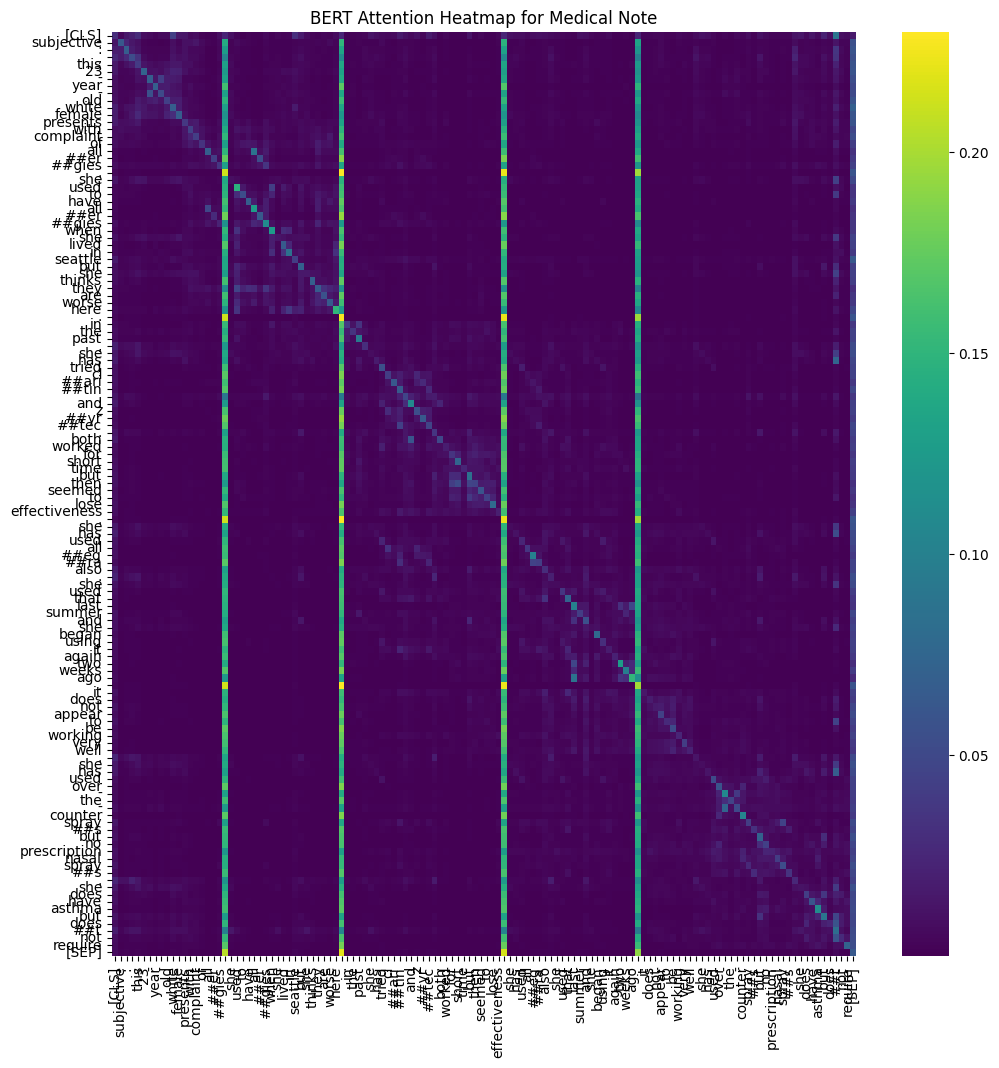

In [1]:

import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/content/mtsamples.csv')


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
model.eval()


sample_text = data.loc[0, 'transcription']

inputs = tokenizer(sample_text, return_tensors='pt', truncation=True, max_length=128)


with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions
attention = attentions[-1]
attention = attention.mean(dim=1).squeeze().numpy()
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze().tolist())

plt.figure(figsize=(12, 12))
sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.title('BERT Attention Heatmap for Medical Note')
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


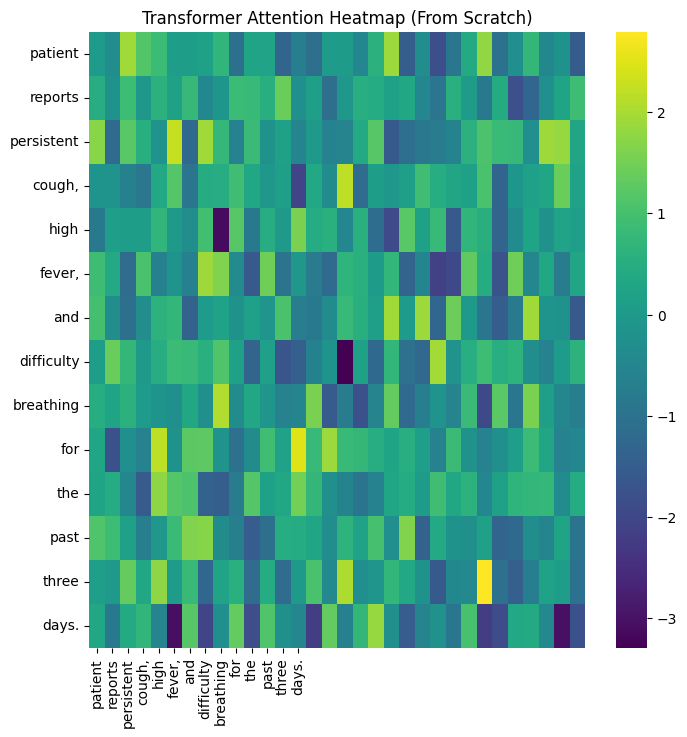

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

sample_text = "Patient reports persistent cough, high fever, and difficulty breathing for the past three days."


tokens = sample_text.lower().split()
vocab = {word: idx for idx, word in enumerate(set(tokens))}
token_ids = [vocab[word] for word in tokens]

input_tensor = torch.tensor([token_ids])

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead, num_encoder_layers=num_layers
        )
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, src):
        embedded = self.embedding(src)
        out = self.transformer(embedded, embedded)
        out = self.fc(out)
        return out, embedded

VOCAB_SIZE = len(vocab)
D_MODEL = 32
NHEAD = 2
NUM_LAYERS = 2

model = TransformerModel(VOCAB_SIZE, D_MODEL, NHEAD, NUM_LAYERS)


output, attention_weights = model(input_tensor)


attention_weights = attention_weights.detach().numpy()[0]

plt.figure(figsize=(8, 8))
sns.heatmap(attention_weights, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.title('Transformer Attention Heatmap (From Scratch)')
plt.show()
